In [37]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [38]:
M = 16 # lattices


#center, right, left, up, down
wts = (2/6,1/6,1/6,1/6,1/6)
e = (0,1,-1,1,-1) 
cs = np.sqrt(3) # instead of 1/sqrt(3)
U = 1 #velocity of moving wall for cavity flow    

In [39]:
vorticity = np.zeros((M,M))
streamfunction = np.zeros((M,M))

In [40]:
def uv(streamfunc):
    #u = streamfunction_y, v = -streamfunction_x
    v = (streamfunc[:,1:]-streamfunc[:,:-1])
    u = streamfunc[1:,:]-streamfunc[:-1,:]
    
    v = np.append(v,np.reshape(v[:,-1],(M,1)),axis=1)
    u = np.append(u,u[-1:],axis=0)
    
    v*=-1
    
    return u,v

def collision_f(vort, u_vels, v_vels):
    # for f, weights have to be calculated by advection diffusion eq, but u and v must be calculated
    def coef(link,vel):
        return wts[link]*(1+e[link]*vel/cs**2)
    func = np.vectorize(coef)
    
    ret = np.zeros((5,M,M))
    ret[0] = func(0,np.zeros((M,M)))*vort.copy()
    ret[1] = func(1,u_vels)*vort.copy()
    ret[2] = func(2,u_vels)*vort.copy()
    ret[3] = func(3,v_vels)*vort.copy()
    ret[4] = func(4,v_vels)*vort.copy()
    return ret

def collision_g(streamfunc):
    # for g, weights are wts tuple
    return [streamfunc.copy()*wts[0],streamfunc.copy()*wts[1],streamfunc.copy()*wts[2],streamfunc.copy()*wts[3],streamfunc.copy()*wts[4]]

def source(streams,vort):
    #streams->(5,M,M), vort-> (M,M)
    S = 1*vort.copy()
    ret = np.zeros((5,M,M))
    for link in range(5):
        ret[link] = streams[link]+wts[link]*S.copy()
    return ret

def prop(st): #works for both
    st1 = st.copy()
    
    lshift = np.eye(N=M,k=-1)
    lshift[0][-1]=1
    
    rshift = np.eye(N=M,k=1)
    rshift[-1][0]=1
    
    st1[2] = np.matmul(st1[2],lshift) #left
    st1[1] = np.matmul(st1[1],rshift) #right
    st1[4] = np.transpose(np.matmul(np.transpose(st1[4]),rshift)) #dow
    st1[3] = np.transpose(np.matmul(np.transpose(st1[3]),lshift)) #up
    return st1

def f_bounds(vorts,streamfunc):
    vorts[1][:,0] = -1*(vorts[0][:,0]+vorts[2][:,0]+vorts[3][:,0]+vorts[4][:,0])-2*streamfunc[:,1]
    vorts[2][:,-1] = -1*(vorts[0][:,-1]+vorts[1][:,-1]+vorts[3][:,-1]+vorts[4][:,-1])-2*streamfunc[:,-2]
    vorts[3][-1,:] = -1*(vorts[0][-1,:]+vorts[1][-1,:]+vorts[2][-1,:]+vorts[4][-1,:])-2*streamfunc[-2,:]
    vorts[4][0,:] = -1*(vorts[0][0,:]+vorts[1][0,:]+vorts[2][0,:]+vorts[3][0,:])-2*streamfunc[1,:]-2*U
    
def g_bounds(streams):
    #center, right, left, up, down --reversed
    streams[1][:,0] = -1*(streams[0][:,0]+streams[2][:,0]+streams[3][:,0]+streams[4][:,0])
    streams[2][:,-1] = -1*(streams[0][:,-1]+streams[1][:,-1]+streams[3][:,-1]+streams[4][:,-1])
    streams[3][-1,:] = -1*(streams[0][-1,:]+streams[1][-1,:]+streams[2][-1,:]+streams[4][-1,:])
    streams[4][0,:] = -1*(streams[0][0,:]+streams[1][0,:]+streams[2][0,:]+streams[3][0,:])
    
def macros(st): # works for both
    return st[0]+st[1]+st[2]+st[3]+st[4]


In [41]:
timesteps = 80
allvorts = [vorticity.copy()]
allstreams = [streamfunction.copy()]
for i in range(timesteps): 
    #initial
    u,v = uv(streamfunction) # (M,M)
    
    #collision
    vorts = collision_f(vorticity,u,v) # (5,M,M)

    streams = collision_g(streamfunction)# (5,M,M)
    streams = source(streams,vorticity)# (5,M,M)

    #propagation
    vorts, streams = prop(vorts), prop(streams)

    #bounds/macros
    g_bounds(streams)
    streamfunction = macros(streams)
    
    f_bounds(vorts,allstreams[-1])
    vorticity = macros(vorts)

    #saving data
    allvorts.append(vorticity.copy())
    allstreams.append(streamfunction.copy())
    
    np.savetxt('classRes/stream'+str(i+1)+'.csv', allstreams[-1], delimiter=',')
    np.savetxt('classRes/vort'+str(i+1)+'.csv', allvorts[-1], delimiter=',')

In [42]:
def graphContour(st,it,levels):
    fig, ax = plt.subplots()
    CS = ax.contour(np.arange(16), np.arange(16), st, levels = levels)
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title('t='+str(it))
    ax.set_aspect('equal', adjustable='box')

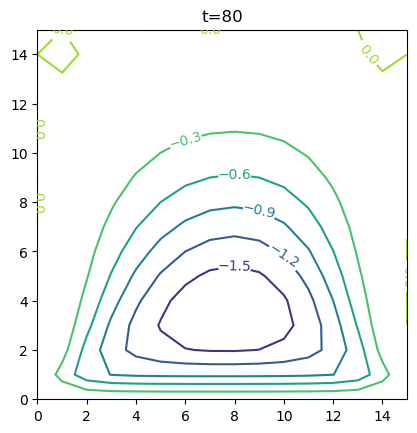

In [44]:
graphContour(allstreams[-1],80,5)